# Imports

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from modularisation.vdp_utils import *
from modularisation.model_utils import *
from modularisation.eval_utils import *
from modularisation.magnetic_field import *
from modularisation.particle import *

# VDP

### Functions


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from mpl_toolkits.mplot3d import Axes3D  # 3D projection
import numpy as np
import os
import time
import math

In [7]:
# parameters
dt = 0.1  # time step
t_end = 30  # total time
t0 = 0  # initial time
N = int(t_end / dt)  # number of time steps
M = 10
device = "cuda" if torch.cuda.is_available() else "cpu"

### Single step predictions 

#### VDP Data load in

In [8]:
X_loaded, K_loaded = torch.load("Data/VDP/VDP_Training.pt")

X, K = X_loaded.to(device), K_loaded.to(device)

#### VDP Example training

In [9]:
# 1) Select device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 2) RK4 tableau
rk4 = {
    "A": [
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0],
    ],
    "b": [1/6, 1/3, 1/3, 1/6],
    "c": [0.0, 0.5, 0.5, 1.0],
}

# 3) Create model & optimizer
model = NeuralRK(hidden_dim=16, num_layers=2, butcher=rk4, dt=dt).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model.num_layers, model.hidden_dim, model.dt)

# 4) Make sure your training data X,K are on the same device
X = X.to(device)
K = K.to(device)

# 5) Convergence parameters
min_epochs = 100
patience   = 20
delta_tol  = 1e-6
max_epochs = 100000     # safety cap
batch_size = 64

best_loss = float("inf")
wait      = 0
epoch     = 0

# 6) Training loop
if not model.does_model_exist("VDP", "RK4"):
    print("Starting training...")
    print(f'model name : NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt')
    while True:
        # Sample a random batch (on-device)
        idx = torch.randperm(X.size(0), device=device)[:batch_size]
        x_batch = X[idx]
        k_batch = K[idx]

        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        # Initialize best_loss on the first epoch
        if epoch == 0:
            best_loss = loss_val

        # Logging
        if epoch % 100 == 0:
            print(f"Epoch {epoch:5d} | Loss = {loss_val:.6e} | Best = {best_loss:.6e} | Wait = {wait}")

        # Check convergence once we've done min_epochs
        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"\nConverged at epoch {epoch} | loss = {loss_val:.6e}")
                    break
            else:
                best_loss = loss_val
                wait = 0

        epoch += 1
        if epoch >= max_epochs:
            print("\nStopping early: reached max epochs.")
            break

    # Save the model
    if not os.path.exists("RK_PINNs/Results/VDP/Models"):
        os.makedirs("RK_PINNs/Results/VDP/Models")

    model.save_model("VDP", "RK4")

elif model.does_model_exist("VDP", "RK4"):
    print(f'Model already exists: NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt')
    model.load_state_dict(torch.load(model.name_model("VDP", "RK4"))["model_state_dict"])

    print("Model loaded successfully.")


Using device: cuda
2 16 0.1
Checked path: Results\VDP\Models\NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt
Checked path: Results\VDP\Models\NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt
Model already exists: NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt
Model loaded successfully.


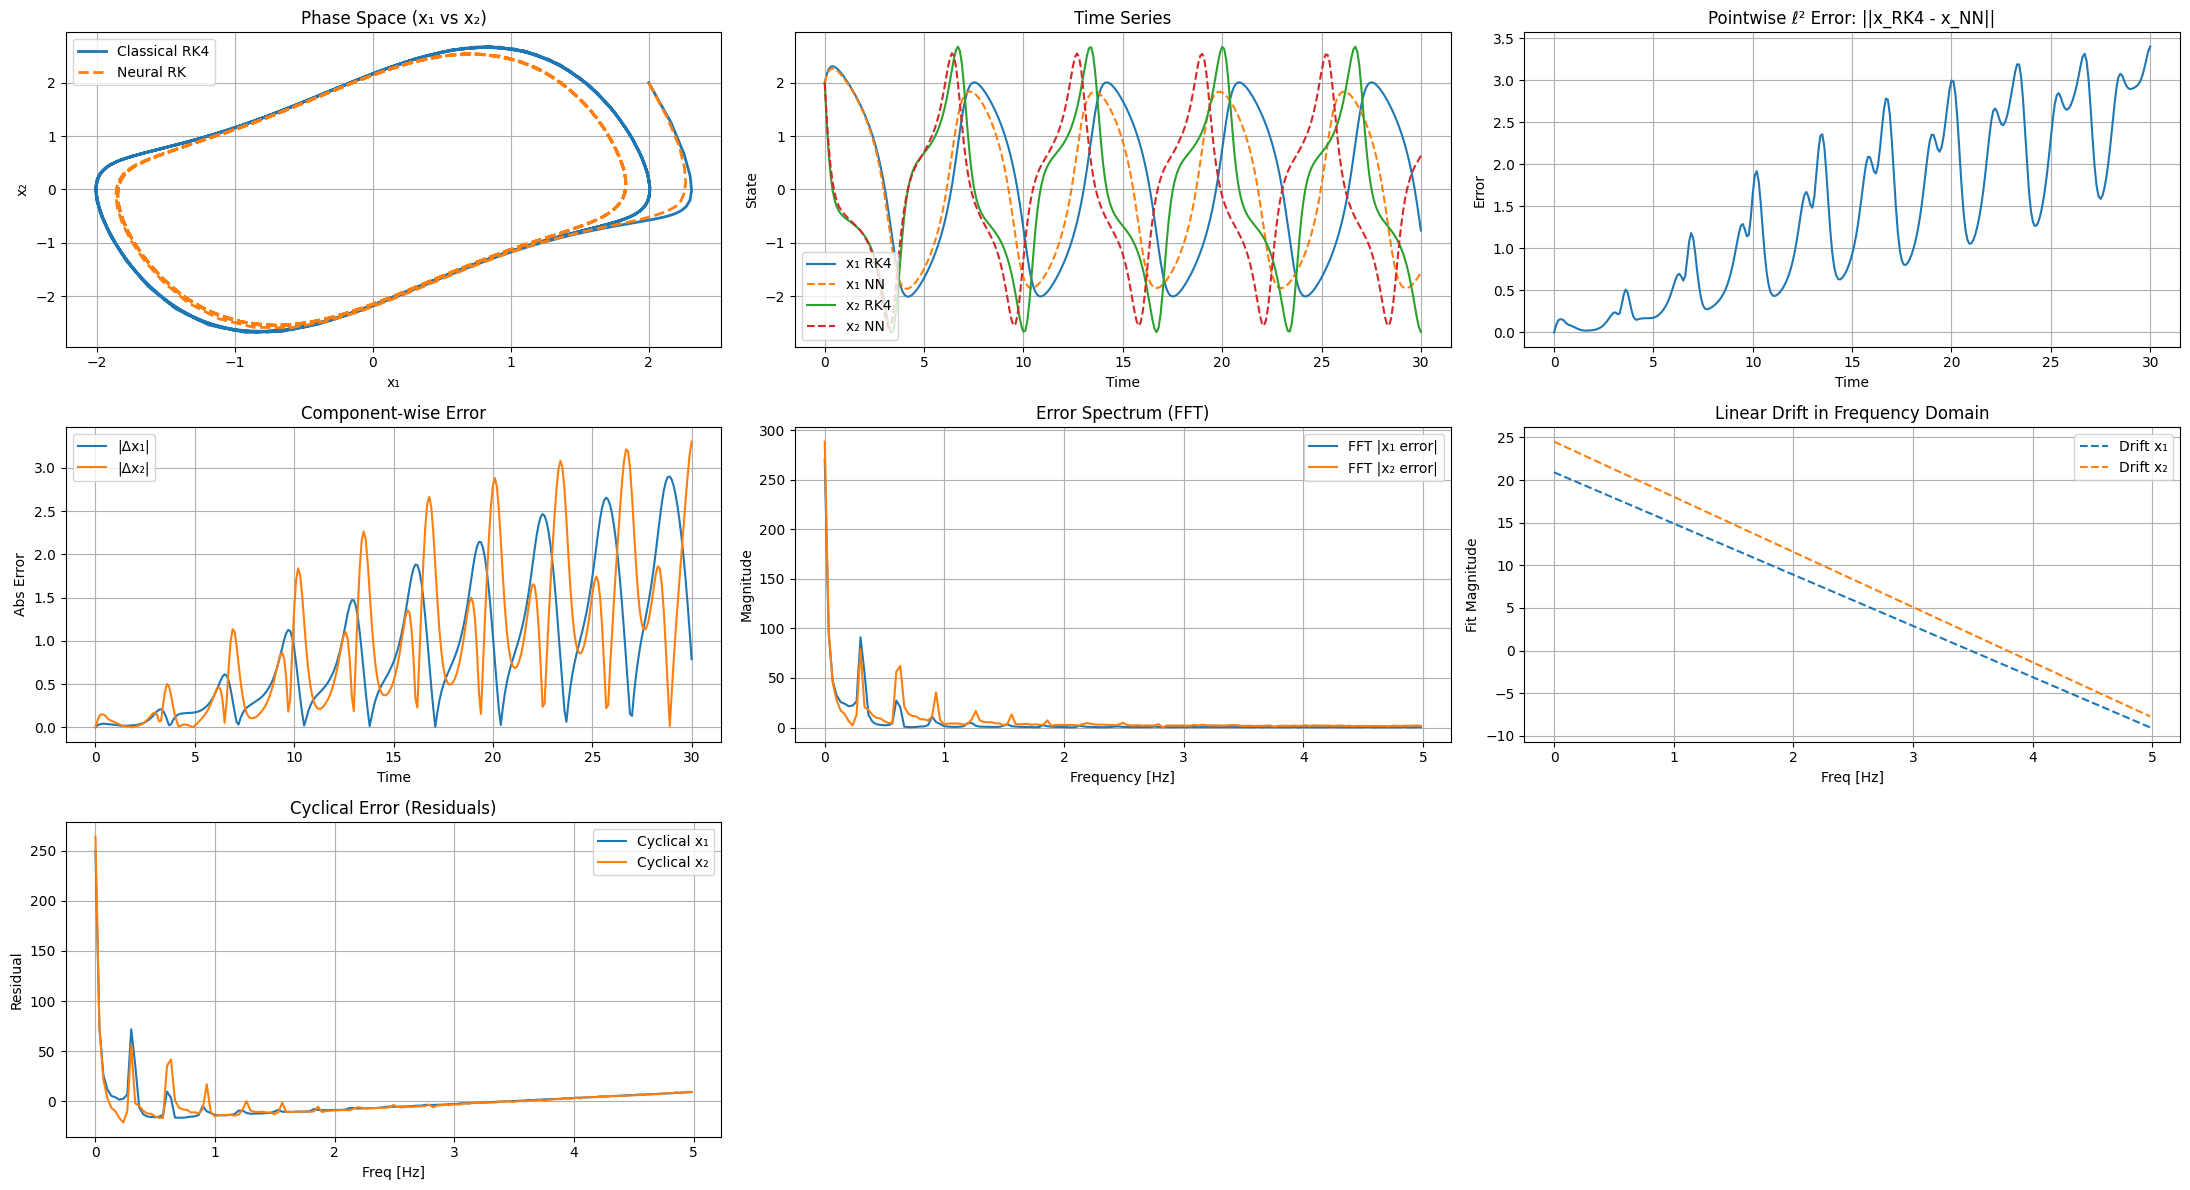

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import rfft, rfftfreq

# === Parameters ===
steps = N
x0 = torch.tensor([2, 2], dtype=torch.float32).to(device)

# === Rollouts ===
traj_nn = rollout_neural_model(model, x0, steps, dt)
traj_rk = rollout_rk4(x0, steps, dt, 10, rk4, vdp)

full_mode_analysis(traj_rk, traj_nn, steps, dt)


In [11]:
# Generate multiple initial conditions
n_ic = 20
x0_set = torch.stack([
    torch.tensor([torch.rand(1).item() * 4 - 2, torch.rand(1).item() * 4 - 2])
    for _ in range(n_ic)
])

# Compute errors
errors = evaluate_final_error(
    model=model,
    m = M,
    butcher=rk4,
    f=vdp,
    x0_set=x0_set,
    t_end=dt,
    dt=0.1
)

# Report
print("Mean final-time error:", errors.mean().item())
print("Max final-time error: ", errors.max().item())


Mean final-time error: 0.04967523366212845
Max final-time error:  0.4498238265514374


#### Comparing Architectures

In [13]:
# === Configurations ===
hidden_dims = [i for i in [1]]  # hidden dimensions
num_layers_list = [1]
repeats = 1  # optional repeat per config


dt = 0.1
steps = N
device = "cuda" if torch.cuda.is_available() else "cpu"

results = []

# Convergence criterion parameters:
max_epochs = 100000         # Maximum training epochs allowed
tol = 1e-6                 # Minimum loss improvement required
patience = 20              # Number of epochs without improvement to wait

x0_eval = sample_initial_conditions(20).to(device)

# === Loop over Configurations ===
for hidden_dim, num_layers in product(hidden_dims, num_layers_list):
    print(f"Training model with hidden_dim={hidden_dim}, num_layers={num_layers}")
    

    # Initialize model and optimizer
    model = NeuralRK(hidden_dim=hidden_dim, num_layers=num_layers, butcher=rk4, dt=dt).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    

  # Training loop with convergence
    min_epochs = 100
    patience = 20
    delta_tol = 1e-6

    best_loss = float('inf')
    wait = 0
    epoch = 0
    max_epochs = 100000  # safety cap

    if not model.does_model_exist("VDP", "RK4"):

        while True:
            idx = torch.randperm(X.size(0))
            x_batch = X[idx[:64]]
            k_batch = K[idx[:64]]

            optimizer.zero_grad()
            loss = model.loss_fn(x_batch, k_batch)
            loss.backward()
            optimizer.step()

            loss_val = loss.item()

            if epoch % 100 == 0:
                print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

            if epoch >= min_epochs:
                if abs(loss_val - best_loss) < delta_tol:
                    wait += 1
                    if wait >= patience:
                        print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
                        break
                else:
                    wait = 0
                    best_loss = loss_val

            epoch += 1
            if epoch >= max_epochs:
                print("Stopped early: max epochs reached.")
                break
        
        print(f"Converged in {epoch} epochs with best loss {best_loss:.4e}")
        # Save the model
        model.save_model("VDP", "RK4")

Training model with hidden_dim=1, num_layers=1
Checked path: Results\VDP\Models\NeuralRK_VDP_hd1_layers1_dt0.1_RK4.pt


In [14]:
evaluate_and_time_saved_models(steps=1,m=M,butcher=rk4, f=vdp, x0_eval=x0_eval, x0=x0,t_end=dt, dt=0.1, device=device)

Saved results to CSV.


,model,mean_error,max_error,rollout_time,hidden_dim,num_layers,dt
0,NeuralRK_VDP_hd124_layers16_dt0.1_RK4.pt,0.037755,0.536644,0.006152,124,16,0.1
1,NeuralRK_VDP_hd124_layers1_dt0.1_RK4.pt,0.060364,0.723479,0.000000,124,1,0.1
2,NeuralRK_VDP_hd124_layers2_dt0.1_RK4.pt,0.034584,0.323023,0.001506,124,2,0.1
3,NeuralRK_VDP_hd124_layers4_dt0.1_RK4.pt,0.042424,0.385519,0.000000,124,4,0.1
4,NeuralRK_VDP_hd124_layers8_dt0.1_RK4.pt,0.101081,1.475880,0.007490,124,8,0.1
5,NeuralRK_VDP_hd16_layers16_dt0.1_RK4.pt,0.059088,0.489774,0.001000,16,16,0.1
6,NeuralRK_VDP_hd16_layers1_dt0.1_RK4.pt,0.082711,0.782174,0.000000,16,1,0.1
7,NeuralRK_VDP_hd16_layers2_dt0.1_RK4.pt,0.100060,0.987130,0.000000,16,2,0.1
8,NeuralRK_VDP_hd16_layers4_dt0.1_RK4.pt,0.065645,0.625673,0.000000,16,4,0.1
9,NeuralRK_VDP_hd16_layers8_dt0.1_RK4.pt,0.095077,0.961671,0.000000,16,8,0.1


c:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\modularisation\eval_utils.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hidden_dim'] = df['model'].str.extract(r'hd(\d+)').astype(float)
c:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\modularisation\eval_utils.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_layers'] = df['model'].str.extract(r'layers(\d+)').astype(float)


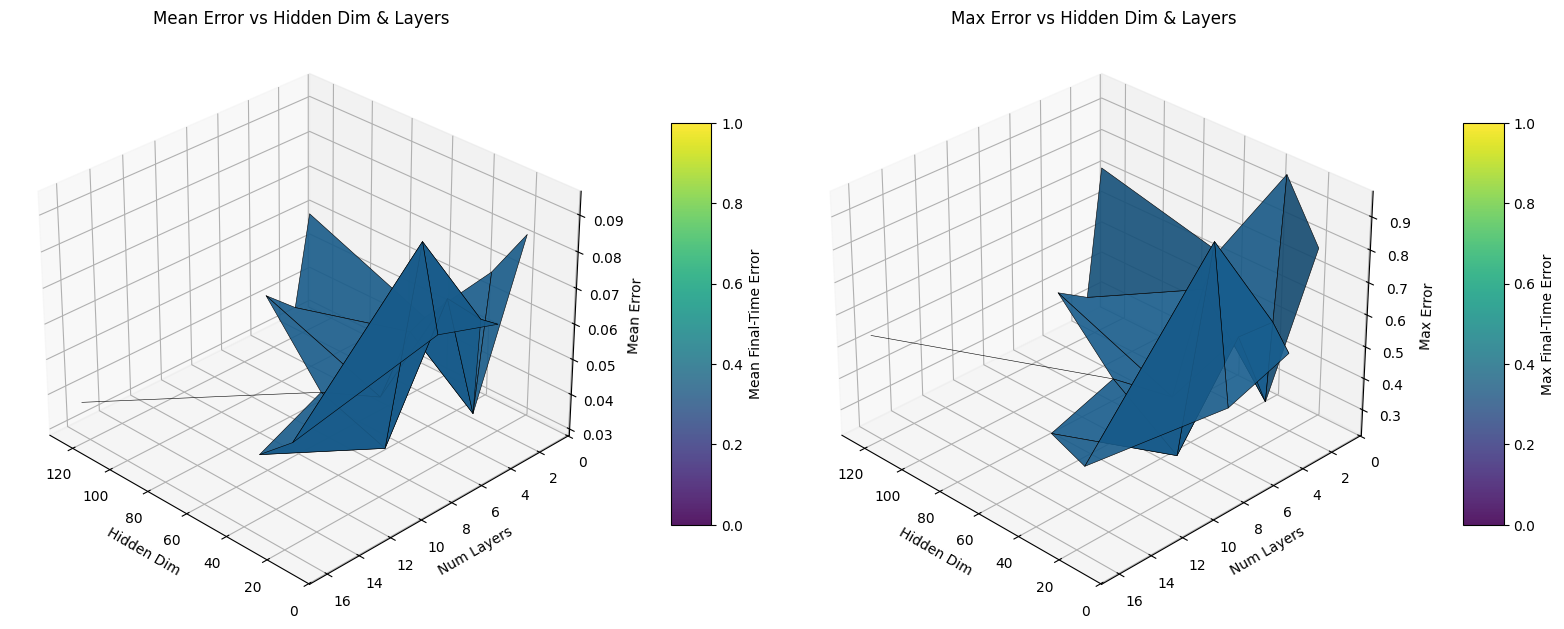

In [15]:
df = pd.read_csv("rk_nn_saved_models_evaluation_with_timing.csv")
plot_mean_and_max_errors_separately(df[df['mean_error'] < 0.1])  # Filter for better visibility

c:\Users\GeorgeWilliam\.conda\envs\TE\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


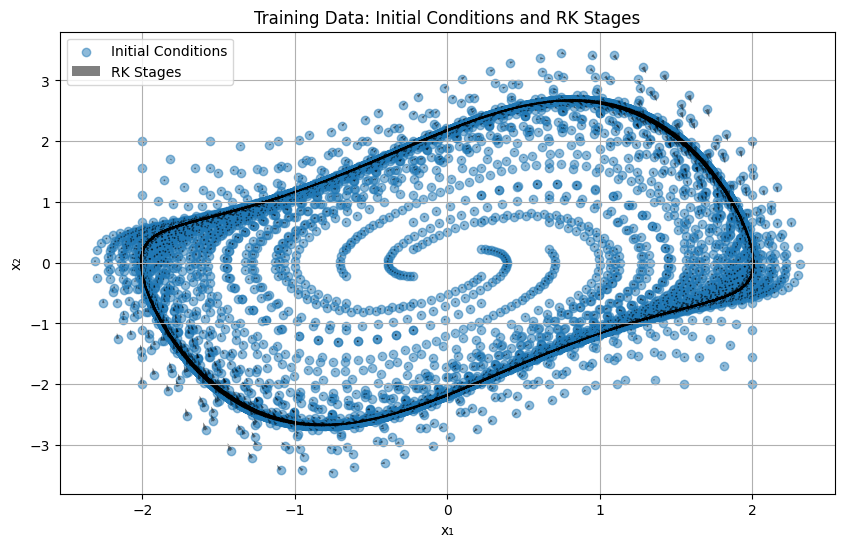

In [12]:
plot_training_data(X, K)

Saved results to CSV.
Evaluating RK4 with M=1
Mean Error: 1.5757848814246245e-05, Max Error: 3.151569762849249e-05, Duration: 0.0047s
Evaluating RK4 with M=2
Mean Error: 5.331201577973843e-07, Max Error: 1.0662403155947686e-06, Duration: 0.0080s
Evaluating RK4 with M=3
Mean Error: 1.3328003944934608e-07, Max Error: 2.6656007889869215e-07, Duration: 0.0129s
Evaluating RK4 with M=4
Mean Error: 5.960464477539063e-08, Max Error: 1.1920928955078125e-07, Duration: 0.0226s
Evaluating RK4 with M=5
Mean Error: 1.3328003944934608e-07, Max Error: 2.6656007889869215e-07, Duration: 0.0210s
Evaluating RK4 with M=6
Mean Error: 1.1920928955078125e-07, Max Error: 2.384185791015625e-07, Duration: 0.0251s
Evaluating RK4 with M=7
Mean Error: 1.1920928955078125e-07, Max Error: 2.384185791015625e-07, Duration: 0.0292s
Evaluating RK4 with M=8
Mean Error: 0.0, Max Error: 0.0, Duration: 0.0320s
Evaluating RK4 with M=9
Mean Error: 1.3328003944934608e-07, Max Error: 2.6656007889869215e-07, Duration: 0.0324s
Eval

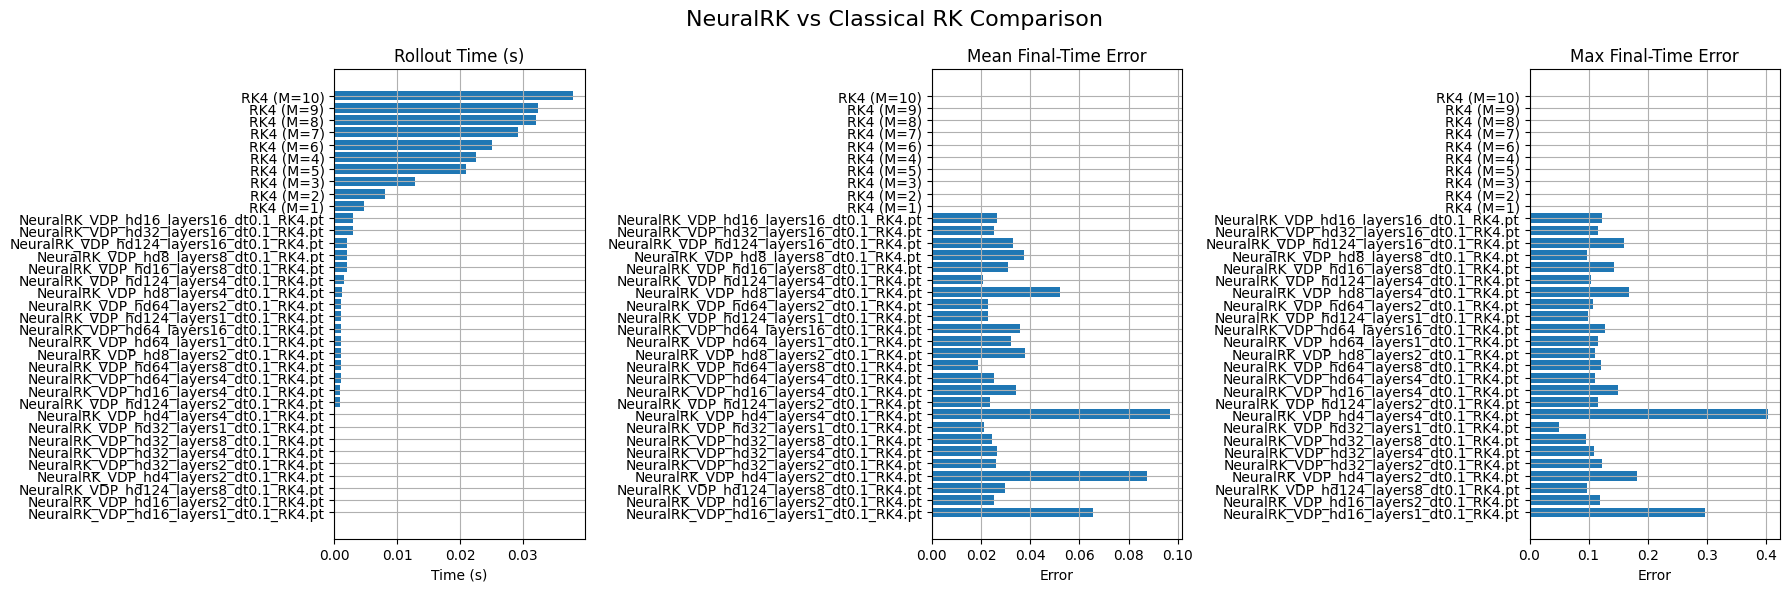

In [13]:
# === Run evaluation ===
df_nn = evaluate_and_time_saved_models(steps=1,m=M,butcher=rk4, f=vdp, x0_eval=x0_eval, x0=x0,t_end=0.1, dt=0.1, device=device)
df_rk = rk_timmer(steps=1,m = 10, Ms=[i for i in range(1, 11)],model=model,butcher=rk4,x0_eval=x0_eval,x0=x0,t_end=dt, dt=dt,f=vdp)

# === Plot results ===
plot_accuracy_and_timing_comparison(df_nn[df_nn['mean_error'] < 0.1], df_rk)


## NN for full trajectories

#### Reshape data

In [ ]:
X_loaded, K_loaded = torch.load("Data/VDP/VDP_Training.pt")

X, K = X_loaded.to(device), K_loaded.to(device)

In [14]:
K_ = K.reshape(K.shape[0]//(int((t_end - t0) / dt) + 1),int((t_end - t0) / dt) + 1,4,2)
X_ = X.reshape(X.shape[0]//(int((t_end - t0) / dt) + 1),int((t_end - t0) / dt) + 1,2)

In [ ]:

# === Select Device ===
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# === Create Model ===
output_dim = math.prod(K_.shape[1:])
print(f"Output dimension: {output_dim}")
model = NeuralRK(hidden_dim=64, num_layers=4, output_dim=output_dim, butcher=rk4, dt=0.1).to(device)

# === Custom Forward & Loss Functions ===
def forward(x):
    x = x.view(x.size(0), -1)
    k = model.net(x)
    return k

def traj_loss(x_, k_):
    k_pred = model.forward(x_)

    return torch.mean((k_pred - k_)** 2)

model.forward = forward
model.loss_fn = traj_loss

# === Optimizer ===
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(f"Model Configuration: {model.num_layers} layers | {model.hidden_dim} hidden dim | dt = {model.dt}")

# === Prepare Data ===
X_ = X_.to(device)
K_ = K_.to(device)
print(f'Shape on device : X_ = {X_.shape}, K_ = {K_.shape}')

# === Convergence Parameters ===
min_epochs = 100
patience = 20
delta_tol = 1e-9
max_epochs = 1000000
batch_size = 64

# === Training or Load Check ===
if not model.does_model_exist("VDP", "RK4_traj"):
    print("Starting training...")
    print(f"Model: NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt")

    best_loss = float("inf")
    wait = 0
    epoch = 0

    while True:
        idx = torch.randperm(X_.size(0), device=device)[:batch_size]
        x_batch = X_[idx,0]
        k_batch = K_[idx]
     
        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch.reshape(batch_size, -1))
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        if epoch == 0:
            best_loss = loss_val

        if epoch % 100 == 0:
            print(f"Epoch {epoch:5d} | Loss = {loss_val:.6e} | Best = {best_loss:.6e} | Wait = {wait}")

        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"\nConverged at epoch {epoch} | loss = {loss_val:.6e}")
                    break
            else:
                best_loss = loss_val
                wait = 0

        epoch += 1
        if epoch >= max_epochs:
            print("\nStopping early: reached max epochs.")
            break

    # Save model
    model.save_model("VDP", "RK4_traj")

else:
    print(f"Model already exists: NeuralRK_VDP_hd{model.hidden_dim}_layers{model.num_layers}_dt{model.dt}_RK4.pt")
    model.load_state_dict(torch.load(model.name_model("VDP", "RK4_traj"))["model_state_dict"])
    print("Model loaded successfully.")


Using device: cuda
Output dimension: 602
Model Configuration: 4 layers | 64 hidden dim | dt = 0.1
Shape on device : X_ = torch.Size([100, 301, 2]), K_ = torch.Size([100, 301, 4, 2])
Checked path: Results\VDP\Models\NeuralRK_VDP_hd64_layers4_dt0.1_RK4_traj.pt
Model already exists: NeuralRK_VDP_hd64_layers4_dt0.1_RK4.pt
Model loaded successfully.


In [ ]:
T = model(torch.tensor([2.0, 2.0], dtype=torch.float32).to(device).unsqueeze(0)).reshape(1, -1, 4, 2)

In [ ]:
x = torch.tensor([2.0, 2.0]).unsqueeze(0).to(device)
Ks = model(x)
path = torch.zeros((Ks.shape[1], 2), device=device)

In [ ]:
trajectory = rollout_neural_model(model, torch.tensor([2.0, 2.0], dtype=torch.float32).to(device), steps, dt, scheme = "RK4_traj")

tensor([[ 1.3218, -6.9264,  1.2872,  ...,  1.1445, -2.6315,  1.2289]],
       device='cuda:0')
Generated trajectory with 300 steps using RK4_traj scheme.


In [ ]:
trajectory

tensor([[  2.0000,   2.0000],
        [-27.7879, -27.7879],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [  0.0000,   0.0000],
        [ 

In [ ]:
T = create_trajectory_from_ks(model, torch.tensor([2.0, 2.0], dtype=torch.float32).to(device), steps=N, dt=dt)

NameError: name 'create_trajectory_from_ks' is not defined

In [ ]:
#True RK rollout
traj_rk = rollout_rk4(torch.tensor([2.0, 2.0]), steps, dt, 500 , rk4, vdp)

In [ ]:
#plot actually path from RK functions against the NeuralRK model
plt.figure(figsize=(10, 6))
plt.plot(T[:, 0].detach().numpy(), T[:, 1].detach().numpy(), label="NeuralRK Trajectory", color='blue', lw=2)
plt.plot(traj_rk[:, 0].detach().numpy(), traj_rk[:, 1].detach().numpy(), label="RK4 Trajectory", color='orange', lw=2, linestyle='--')
plt.title("NeuralRK Trajectory")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.grid(True)
plt.legend()
plt.show()


[autoreload of modularisation.model_utils failed: Traceback (most recent call last):
  File "c:\Users\GeorgeWilliam\.conda\envs\TE\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\GeorgeWilliam\.conda\envs\TE\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "c:\Users\GeorgeWilliam\.conda\envs\TE\Lib\importlib\__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "c:\Users\GeorgeWilliam\Documents\GitHub\TrackExtrapolation\RK_PINNs\modul

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

<Figure size 1000x600 with 0 Axes>

## dt analysis

## Variable delta t